<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Classifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries to connect to google drive 

In [ ]:
import os
from os import listdir
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Uploading supporting files CreatePestImageData.py and SupportingFunctions.py 

In [ ]:
from google.colab import files
files.upload() 

Saving SupportingFunctions.py to SupportingFunctions.py


{'SupportingFunctions.py': b'import zipfile\r\nimport os\r\nimport re, os.path\r\nimport numpy as np\r\nimport matplotlib.pyplot as plt\r\nfrom sklearn.metrics import accuracy_score\r\nfrom sklearn.metrics import precision_score\r\nfrom sklearn.metrics import recall_score\r\nfrom sklearn.metrics import f1_score\r\nfrom sklearn.metrics import cohen_kappa_score\r\nfrom collections import OrderedDict  \r\n\r\n\r\n\r\n\r\n\r\n\r\ndef DownLoadFiles(folderId,drive):\r\n    file_list = drive.ListFile(\r\n    {\'q\': "\'"+folderId+"\' in parents"}).GetList()\r\n\r\n    for f in file_list:\r\n         print(\'title: %s, id: %s\' % (f[\'title\'], f[\'id\']))\r\n         fname = f[\'title\']\r\n         print(\'downloading to {}\'.format(fname))\r\n         f_ = drive.CreateFile({\'id\': f[\'id\']})\r\n         f_.GetContentFile(fname)\r\n\r\n\r\ndef Unzip(source_Path, dest_Path):\r\n    zip = zipfile.ZipFile(source_Path, \'r\')\r\n    zip.setpassword(b"virus")\r\n    for name in zip.namelist():\

importing supporting files CreatePestImageData.py and SupportingFunctions.py 

In [ ]:
import CreatePestImageData as Imagedataset
import SupportingFunctions as support

Downloading the files from google drive 

'1aXb25Wp9sG7mL6AQgYY9ElrGcERi95JU'  - Id of the base  folder in google drive 
'drive' - the drive object created previously 



In [ ]:
support.DownLoadFiles('1aXb25Wp9sG7mL6AQgYY9ElrGcERi95JU',drive)

Once the files are downloaded , please create a folder structure with 'Pests' as parent folder and 'Images' and 'Labels' folders nested in it

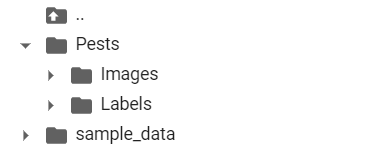

Extracting the images from zip files downloaded to Images folder created
The method should be called repeatedly  till  images from GREENPATROL_DB_V1.0.zip,GREENPATROL_DB_V2.0.zip,GREENPATROL_DB_V3.0.zip are extracted to  'Images' folder and Labels from LABELS_V1.0.zip, LABELS_V2.0.zip and LABELS_V3.0.zip are extracted to  'Labels' folder


In [ ]:
support.Unzip('/content/LABELS_V1.0.zip','/content/Pests/Labels')

In [ ]:
support.fileCount('/content/Pests/Labels')

2000


In [ ]:
dataSet = Imagedataset.createImageDataset()

Defining the class labels 

In [ ]:
class_object = {0 : 'egg_wf' ,
                1 : 'egg_bt', 2 : 'egg_ta', 3 : 'wf', 4 : 'bt', 5 : 'tomato'}

Cropping the images 

In [ ]:
dataSet.prepare_dataset('/content/Pests/Labels' , class_object ,32, '/content/Pests/Images',  test_size=11241 )

Assigning the test and training data 

In [ ]:
(trainY , trainX) , (testY , testX ) = (dataSet.trainY , dataSet.trainX ) , (dataSet.testY , dataSet.testX )


Importing TensorFlow Libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow.keras as ks
import tensorflow as tf 


In [ ]:
from keras import backend as K
if K.image_data_format() == 'channels_first':
   input_shape = [3, 32, 32]
else:
   input_shape = [32, 32, 3]

define the model

In [ ]:

model_with_conv = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu, input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    #  10-node softmax layer, with each node representing a class of clothing.
    tf.keras.layers.Dense(6,  activation=tf.nn.softmax)
])
 
# compile the model
model_with_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_with_conv.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [ ]:
from tensorflow.keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [ ]:
filepath="/content/drive/My Drive/Models/CNN_Scratch/weights-{epoch:02d}-{accuracy:.3f}.hdf5"
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='accuracy',
                               verbose=1, mode='max',save_best_only=True)

callbacks_list = [checkpoint]

In [ ]:
tf.config.experimental_run_functions_eagerly(True)


In [ ]:
(augtrainX,augtrainY) =  support.PrepareAugmentedData(trainX,trainY)

In [ ]:
model_with_conv.fit(trainX,trainY,verbose=1,epochs=50,validation_data=(testX,testY),callbacks=[checkpoint])

Epoch 1/50
1405/1406 [============================>.] - ETA: 0s - loss: 1.5056 - accuracy: 0.6181
Epoch 00001: accuracy improved from -inf to 0.61818, saving model to /content/drive/My Drive/Models/CNN_Scratch/weights-01-0.618.hdf5
1406/1406 [==============================] - 28s 20ms/step - loss: 1.5055 - accuracy: 0.6182 - val_loss: 0.8942 - val_accuracy: 0.6444
Epoch 2/50
1405/1406 [============================>.] - ETA: 0s - loss: 0.8870 - accuracy: 0.6449
Epoch 00002: accuracy improved from 0.61818 to 0.64492, saving model to /content/drive/My Drive/Models/CNN_Scratch/weights-02-0.645.hdf5
1406/1406 [==============================] - 28s 20ms/step - loss: 0.8870 - accuracy: 0.6449 - val_loss: 0.9620 - val_accuracy: 0.6233
Epoch 3/50
1404/1406 [============================>.] - ETA: 0s - loss: 0.8590 - accuracy: 0.6564
Epoch 00003: accuracy improved from 0.64492 to 0.65641, saving model to /content/drive/My Drive/Models/CNN_Scratch/weights-03-0.656.hdf5
1406/1406 [=================

In [ ]:
import json
history_dict = model_with_conv.history.history
json.dump(str(history_dict), open('/content/drive/My Drive/Models/CNN_Scratch/History/CNN_Scratch_History1.json', 'w'))

In [ ]:
acc = model_with_conv.history.history['accuracy']
val_accuracy = model_with_conv.history.history['val_accuracy']
loss  =  model_with_conv.history.history['loss']
val_loss = model_with_conv.history.history['val_loss']

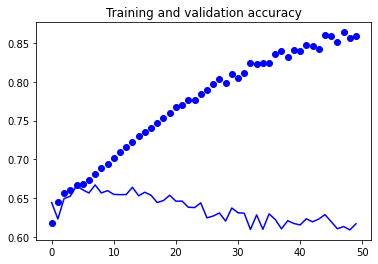

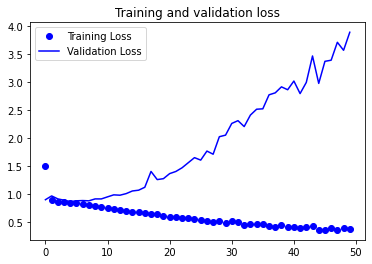

In [ ]:
support.GenerateGraphs(acc, val_accuracy, loss, val_loss)

In [ ]:
support.PrintMetrics(testX_Pred,testY_Pred,model_with_conv)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 0.617116
Precision: 0.485587
Recall: 0.446889
F1 score: 0.458831
Cohens kappa: 0.418860


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
   
  plt.imshow(img[...,0], cmap=plt.cm.binary)
 
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
   
  plt.xlabel("{} {:2.0f}% ({})".format(class_object[predicted_label],
                                100*np.max(predictions_array),
                                class_object[true_label]),
                                color=color)

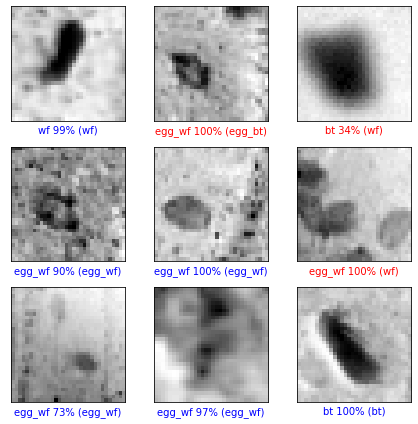

In [ ]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
test_images = testX[:num_images]
predictions = model_with_conv.predict(testX_Pred)
for i in range(num_images):    
    plt.subplot(num_rows, num_cols, i+1)   
    plot_image(i, predictions, testY_Pred, testX_Pred)    
 
plt.tight_layout()
plt.show()